importing requirements

In [24]:
import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt

from hmmlearn import hmm

Utility functions

In [25]:
def set_axes(axes, xlabel, ylabel, title, loc="best"):

    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.legend(loc=loc)
    axes.set_title(title)

# 1. Data Collection and Preprocessing

Data Aquisition

In [26]:
# Creating a Stock Class to store all information related to a stock
class Stock:

    def __init__(self, name) -> None:

        self.name = name

        # data = yf.Ticker(name)

        self.history = yf.download(name, period="2y")


    def get_history(self):
        return self.history


    def daily_percentage_change(self):

        self.history["Daily Percentage Change"] = (

            self.history["Close"].pct_change() * 100
        )

        return self.history["Daily Percentage Change"]

    def calculate_daily_returns(self):

        self.history["Daily Returns"] = self.history["Adj Close"].pct_change()
        self.history["Daily returns"] = self.history["Daily Returns"].fillna(
            0, inplace=True
        )

        self.history['Daily Returns'].dropna()

        return self.history["Daily Returns"]

Initializing Dictionary of Stock objects for 5 stocks from the Nifty 50 index

In [27]:
stock_names = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS", "TCS.NS", "HINDUNILVR.NS"]
stocks = {name: Stock(name) for name in stock_names}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Adjusting closing Prices

In [28]:
for stock in stocks.values():
    stock.daily_percentage_change()  # refer to Stock Class for code of the function
    stock.calculate_daily_returns()

C:\Users\salon\AppData\Local\Temp\ipykernel_8928\1039621438.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.history["Daily returns"] = self.history["Daily Returns"].fillna(
C:\Users\salon\AppData\Local\Temp\ipykernel_8928\1039621438.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

PLOT the closing prices, daily percentage changes and daily returns

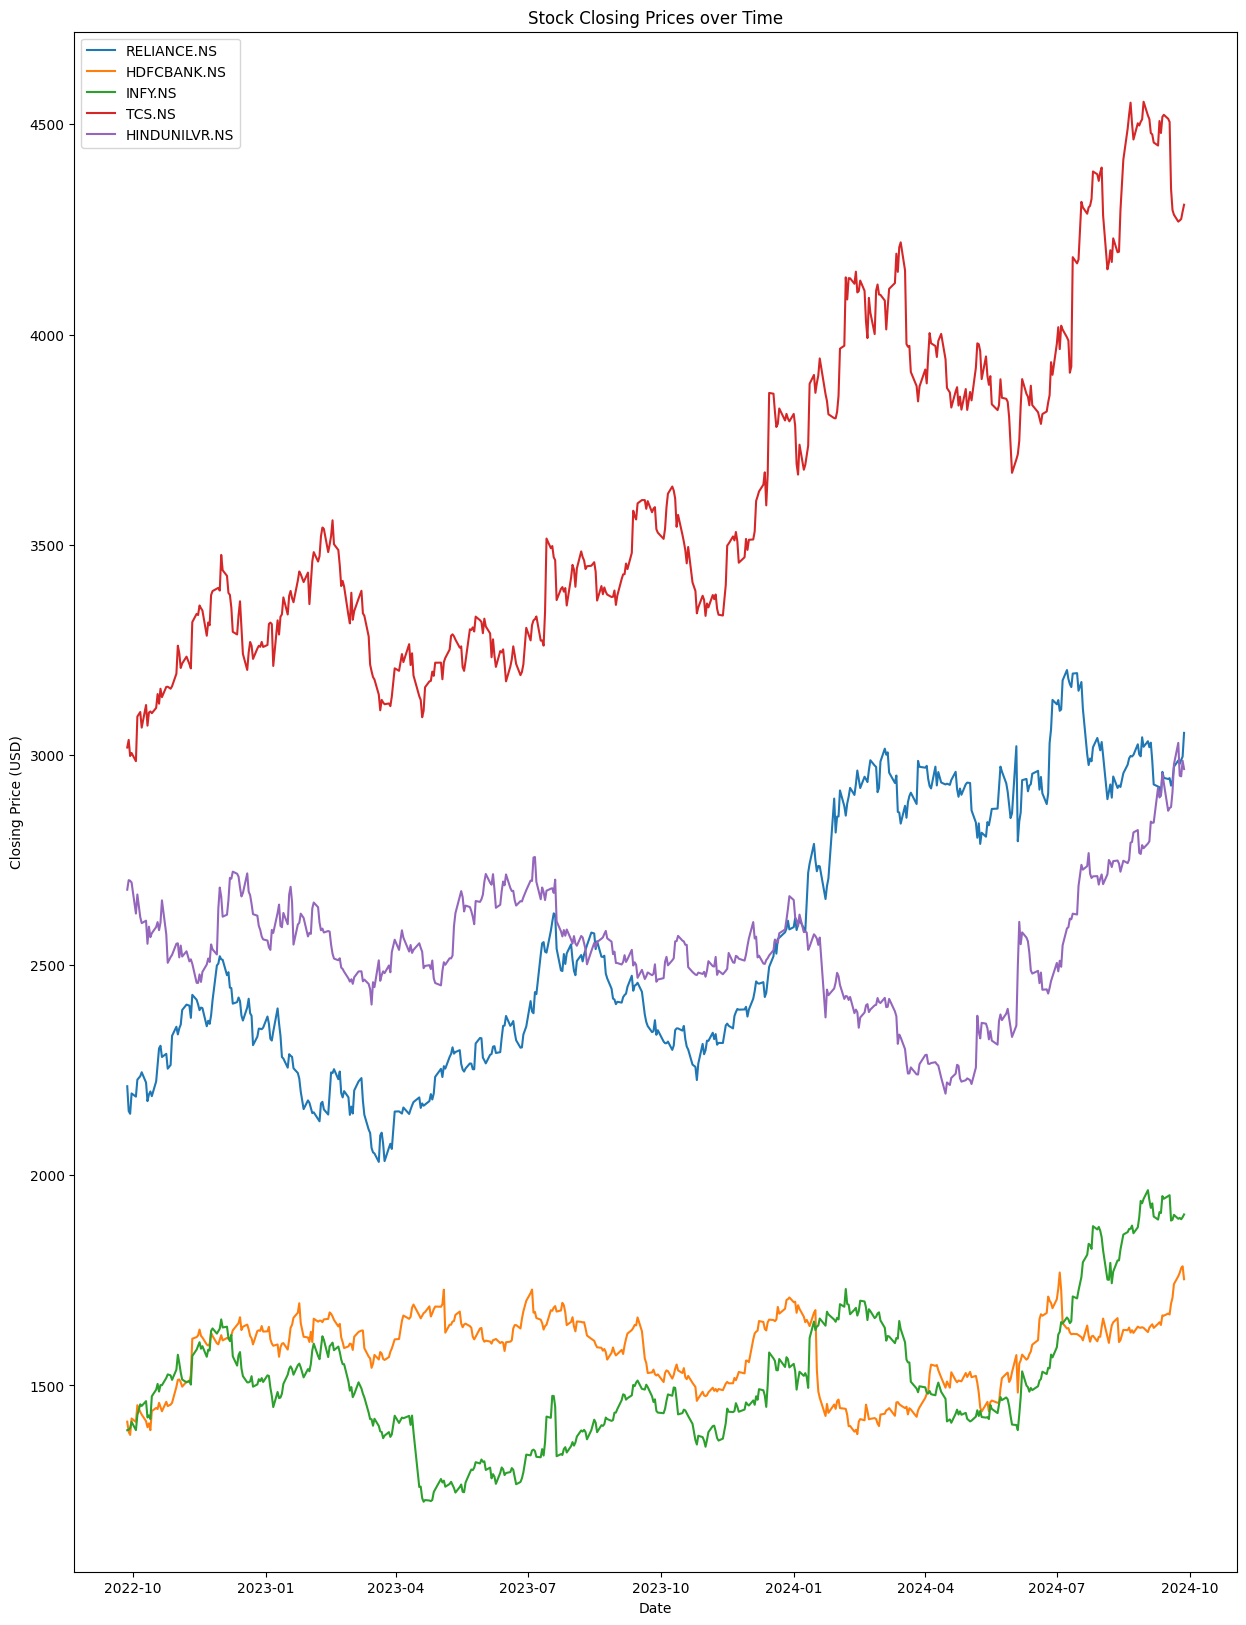

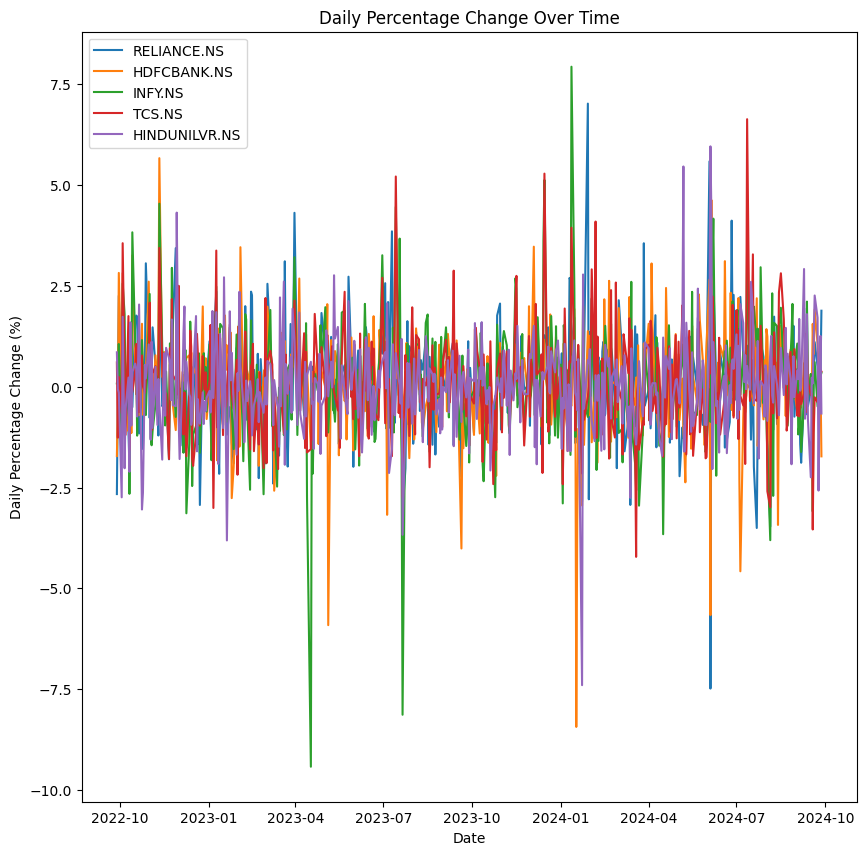

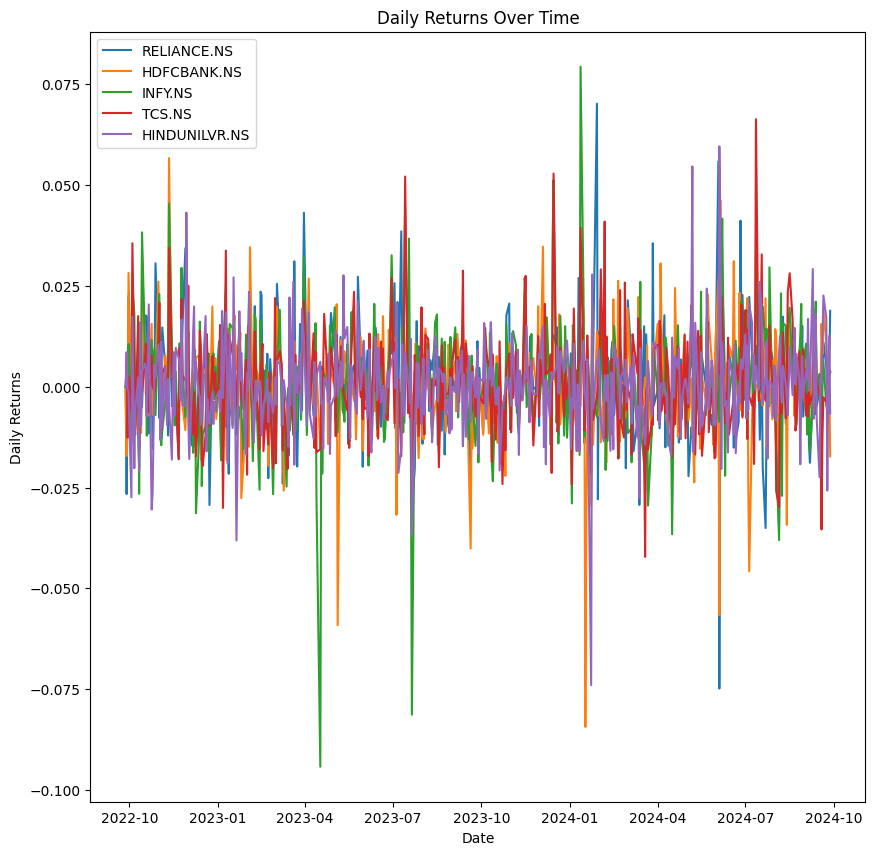

In [29]:
# Initializing figure and axes objects for the plots
closing_price_figure, closing_price_axes = plt.subplots(figsize=(15, 20))
daily_percentage_change_figure, daily_percentage_change_axes = plt.subplots(
    figsize=(10, 10)
)
daily_returns_figure, daily_returns_axes = plt.subplots(figsize=(10, 10))
for stock in stocks.values():

    hist = stock.history

    closing_price_axes.plot(hist["Close"], label=stock.name)
    daily_percentage_change_axes.plot(hist["Daily Percentage Change"], label=stock.name)

    daily_returns_axes.plot(hist["Daily Returns"], label=stock.name)


# refer to utility functions for function definition
set_axes(
    closing_price_axes, "Date", "Closing Price (USD)", "Stock Closing Prices over Time"
)
set_axes(
    daily_percentage_change_axes,
    "Date",
    "Daily Percentage Change (%)",
    "Daily Percentage Change Over Time",
)
set_axes(
    daily_returns_axes,
    "Date",
    "Daily Returns",
    "Daily Returns Over Time",
)

# saving figures to png
closing_price_figure.savefig("closing_price.png")
daily_percentage_change_figure.savefig("daily_percentage_change.png")
plt.show()

# Gaussian Hidden Markov Model

Fitting the Model

In [30]:
# Preparing Data for fitting
sample_stock = Stock("AAPL")
daily_returns = sample_stock.calculate_daily_returns().values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed
C:\Users\salon\AppData\Local\Temp\ipykernel_8928\1039621438.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.history["Daily returns"] = self.history["Daily Returns"].fillna(


In [31]:
n_states = 2

model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=10000)
model.fit(daily_returns)

hidden_states = model.predict(daily_returns)

Analysis of Model Parameters

In [32]:
means = model.means_
variances = model.covars_

print(
    "High Variance indicates volatility\nWhereas negative mean indicates a bear market"
)
params_analysis = pd.DataFrame(
    {
        "State": range(n_states),
        "Means": means.flatten(),
        "Variance": variances.flatten(),
    }
)

mean_var = params_analysis["Variance"].mean()
params_analysis["High Volatility"] = params_analysis["Variance"] > mean_var

for i, row in params_analysis.iterrows():
    print(f"State {i}")
    vol = "HIGH" if row["High Volatility"] else "LOW"
    dir = "BEARISH" if row["Means"] < 0 else "BULLISH"
    print(f"\tMean: {row['Means']}, {dir}")
    print(f"\tVolatility: {row['Variance']}, {vol}")

High Variance indicates volatility
Whereas negative mean indicates a bear market
State 0
	Mean: 0.0010035920794501582, BULLISH
	Volatility: 0.0001537575349665856, LOW
State 1
	Mean: 0.0009555152356460638, BULLISH
	Volatility: 0.0004513959724413328, HIGH


# Interpretation and Inference

Inferred Hidden States

In [33]:
data = sample_stock.history

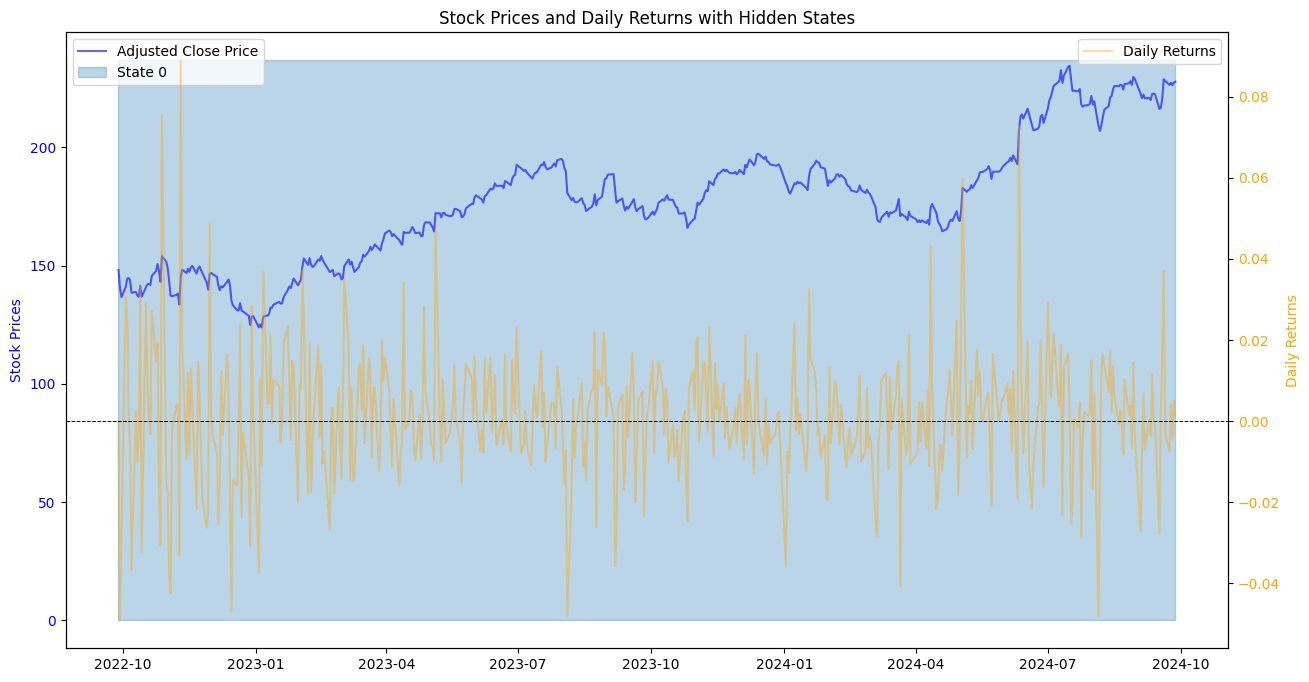

In [34]:
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.set_title('Stock Prices and Daily Returns with Hidden States')
ax1.set_ylabel('Stock Prices', color='blue')
ax1.plot(data.index, data['Adj Close'], label='Adjusted Close Price', color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Daily Returns', color='orange')
ax2.plot(data.index, data['Daily Returns'], label='Daily Returns', color='orange', alpha=0.4)
ax2.tick_params(axis='y', labelcolor='orange')

for i in range(n_states):
    ind = np.where(hidden_states == i)[0]
    
    if ind.size > 0:
        ax1.fill_between(
            data.index[ind],
            data['Adj Close'].max() * 1.01, 
            color=f'C{i}', 
            alpha=0.3, 
            label=f"State {i}"
        )

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.axhline(0, color='black', linestyle='--', linewidth=0.7)  
plt.show()


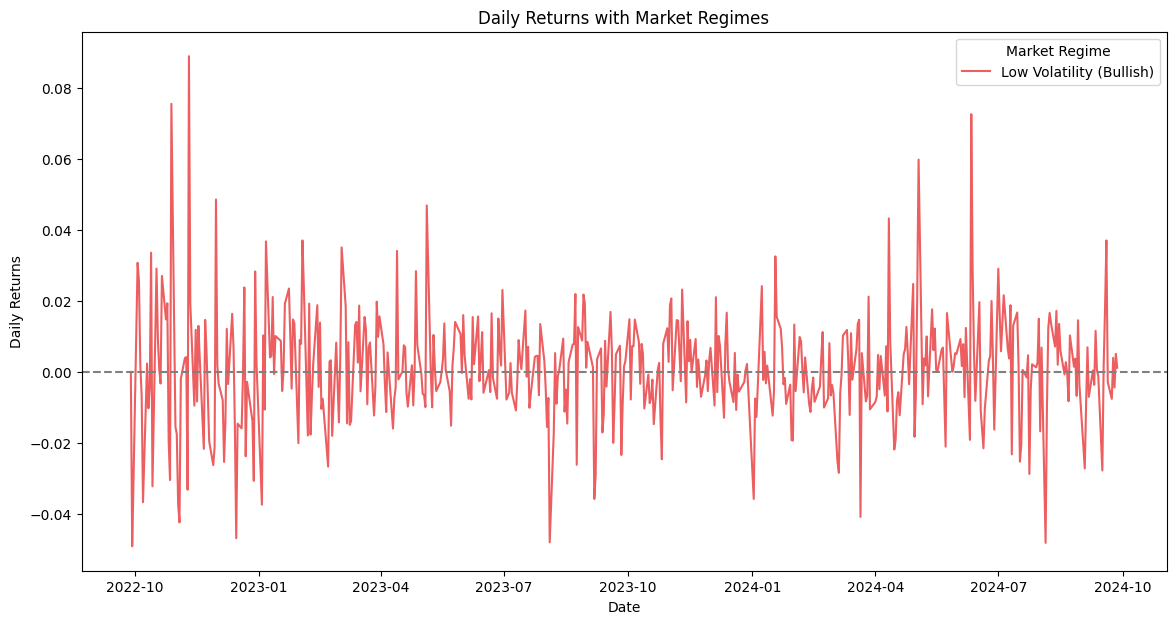

In [35]:
state_mapping = {
    0: 'Low Volatility (Bullish)',
    1: 'Moderate Volatility',
    2: 'High Volatility (Bearish)'
}
data['Hidden State'] = hidden_states
data['Market Regime'] = data['Hidden State'].map(state_mapping)

import seaborn as sns

plt.figure(figsize=(14, 7))
sns.lineplot(data=data, x='Date', y='Daily Returns', hue='Market Regime', palette='Set1', alpha=0.7)
plt.title('Daily Returns with Market Regimes')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Market Regime')
plt.show()


Transition Matrix

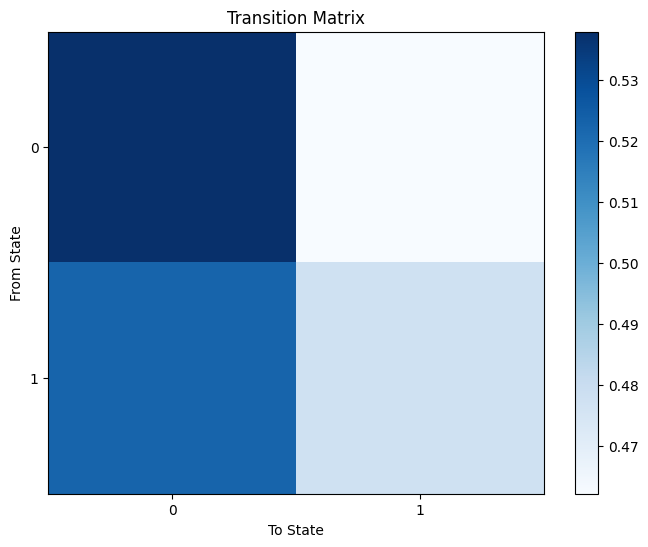

In [36]:
transition_matrix = model.transmat_
plt.figure(figsize=(8, 6))
plt.imshow(transition_matrix, cmap='Blues', aspect='auto')
plt.colorbar()
plt.title('Transition Matrix')
plt.xlabel('To State')
plt.ylabel('From State')
plt.xticks(np.arange(n_states), range(n_states))
plt.yticks(np.arange(n_states), range(n_states))
plt.show()

In [37]:
low_vol_to_high_vol = transition_matrix[0][1]
high_vol_to_low_vol = transition_matrix[1][0]

print(f"Probability of transitioning from Low Volatility to High Volatility: {low_vol_to_high_vol:.2f}")
print(f"Probability of transitioning from High Volatility to Low Volatility: {high_vol_to_low_vol:.2f}")

Probability of transitioning from Low Volatility to High Volatility: 0.46
Probability of transitioning from High Volatility to Low Volatility: 0.52


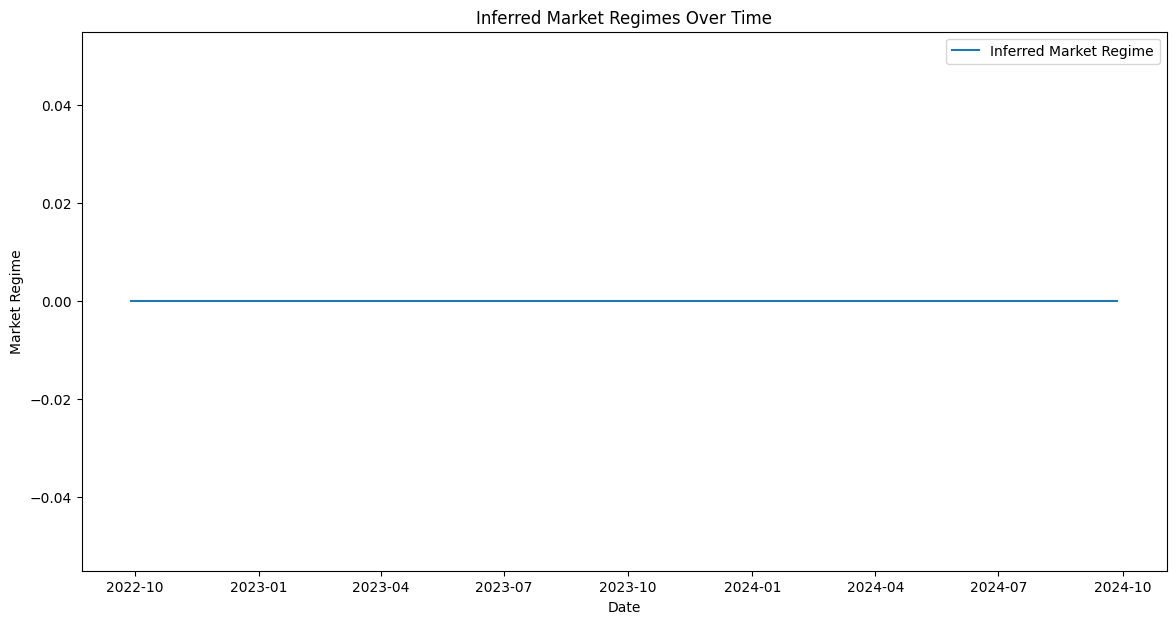

In [38]:
state_df = pd.DataFrame({
    'Date': sample_stock.history.index,
    'Inferred State': hidden_states
})

# Plotting the inferred states
plt.figure(figsize=(14, 7))
plt.plot(state_df['Date'], state_df['Inferred State'], label='Inferred Market Regime')
plt.title('Inferred Market Regimes Over Time')
plt.xlabel('Date')
plt.ylabel('Market Regime')
plt.legend()
plt.show()

Hidden States vs Actual Returns 

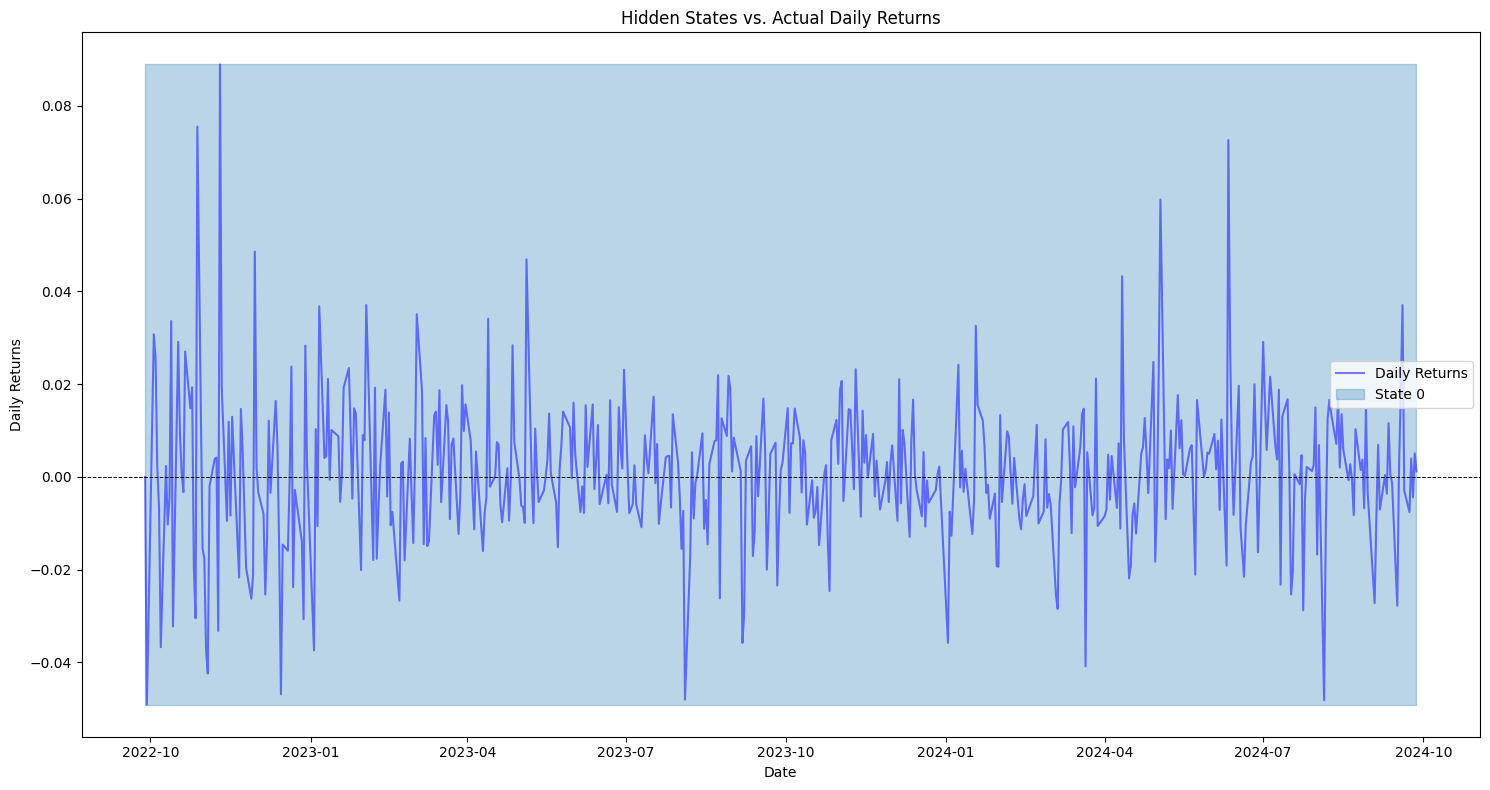

In [39]:
plt.figure(figsize=(15, 8))

# Plot daily returns
plt.plot(data.index, data['Daily Returns'], label='Daily Returns', color='blue', alpha=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)

# Color regions based on hidden states
for i in range(2):  # Assuming there are 2 hidden states
    # Get the indices where the hidden state is i
    ind = np.where(hidden_states == i)[0]
    if ind.size > 0:
        plt.fill_between(
            data.index[ind],  # X values (dates)
            data['Daily Returns'].min(),  # Lower bound for fill
            data['Daily Returns'].max(),  # Upper bound for fill
            color=f'C{i}',  # Use distinct colors for each state
            alpha=0.3,  # Transparency for better visibility
            label=f'State {i}'  # Label for legend
        )

# Set labels and title
plt.title('Hidden States vs. Actual Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.tight_layout()
plt.show()

Performance Metrics Calculations

In [40]:
# Evaluate model fit
log_likelihood = model.score(daily_returns)
aic = model.aic(daily_returns)
bic = model.bic(daily_returns)

print(f"Log Likelihood: {log_likelihood:.2f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")


Log Likelihood: 1421.84
AIC: -2829.69
BIC: -2800.14


Backtesting

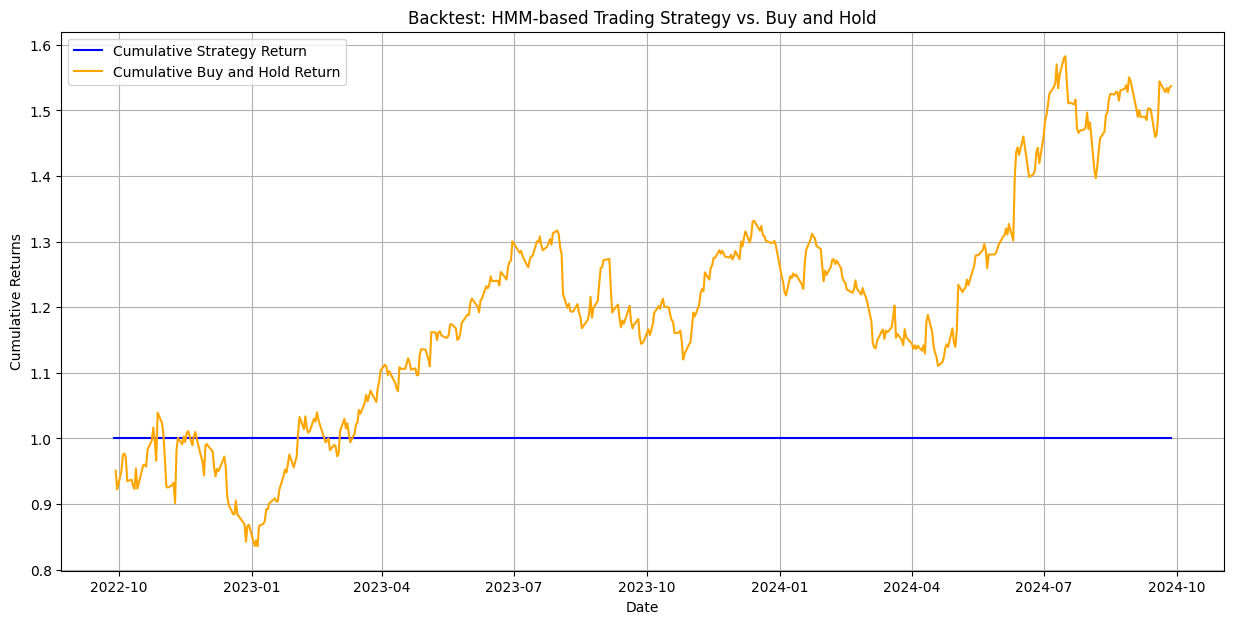

Total Strategy Return: 0.00%
Total Buy and Hold Return: 53.71%
Sharpe Ratio: nan


C:\Users\salon\AppData\Local\Temp\ipykernel_8928\368902096.py:27: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(data['Strategy Return']) / np.std(data['Strategy Return']) * np.sqrt(252)  # Assuming 252 trading days


In [41]:
data['Daily Return'] = data['Adj Close'].pct_change()

# Define the trading strategy based on hidden states
# Assume that hidden state 1 indicates a "buy" signal
data['Strategy Return'] = np.where(hidden_states == 1, data['Daily Return'], 0)

# Cumulative returns for the strategy
data['Cumulative Strategy Return'] = (1 + data['Strategy Return']).cumprod()

# Cumulative returns for the buy-and-hold strategy
data['Cumulative Buy and Hold Return'] = (1 + data['Daily Return']).cumprod()

# Visualize the performance of the strategy
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['Cumulative Strategy Return'], label='Cumulative Strategy Return', color='blue')
plt.plot(data.index, data['Cumulative Buy and Hold Return'], label='Cumulative Buy and Hold Return', color='orange')
plt.title('Backtest: HMM-based Trading Strategy vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

# Performance metrics
total_strategy_return = data['Cumulative Strategy Return'].iloc[-1] - 1
total_bh_return = data['Cumulative Buy and Hold Return'].iloc[-1] - 1
sharpe_ratio = np.mean(data['Strategy Return']) / np.std(data['Strategy Return']) * np.sqrt(252)  # Assuming 252 trading days

print(f"Total Strategy Return: {total_strategy_return:.2%}")
print(f"Total Buy and Hold Return: {total_bh_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


State Durations

State Durations:
   State  Duration
0      0       503
1      1         0


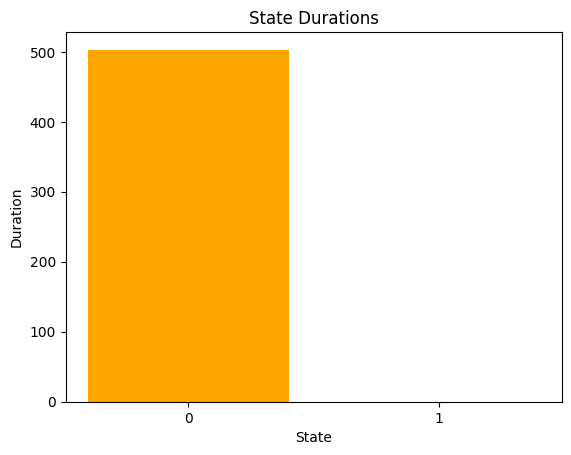

In [42]:
durations = []
for i in range(n_states):
    state_indices = np.where(hidden_states == i)[0]
    durations.append(len(state_indices))

state_durations_df = pd.DataFrame({
    'State': range(n_states),
    'Duration': durations
})

print("State Durations:")
print(state_durations_df)

# Visualize state durations
plt.bar(state_durations_df['State'], state_durations_df['Duration'], color='orange')
plt.title('State Durations')
plt.xlabel('State')
plt.ylabel('Duration')
plt.xticks(state_durations_df['State'])
plt.show()

# Conclusion and Insights

Using a transition matrix to predict future states

In [43]:
curr_state = 0

future_state_probabilities = transition_matrix[curr_state]
state_labels = ['Low Volatility', 'High Volatility']
market_dir = ['Bearish','Bullish']
predicted_states = pd.DataFrame({
    'State': state_labels,
    'Probability': future_state_probabilities,
    'Market Direction': market_dir
})

print("Predicted Future State Probabilities:")
print(predicted_states)

# Determine the most likely future state
most_likely_state = np.argmax(future_state_probabilities)
print(f"\nMost Likely Future State: {state_labels[most_likely_state]} ({market_dir[most_likely_state]})")

Predicted Future State Probabilities:
             State  Probability Market Direction
0   Low Volatility     0.537877          Bearish
1  High Volatility     0.462123          Bullish

Most Likely Future State: Low Volatility (Bearish)
